# Setup

In [ ]:
!pip install kaggle


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


## Loading Dataset

In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets download -d moazeldsokyx/plantvillage -p /content/



 98% 321M/329M [00:03<00:00, 79.8MB/s]
100% 329M/329M [00:03<00:00, 93.3MB/s]


In [ ]:
!unzip plantvillage.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/Tomato__Tomato_YellowLeaf__Curl_Virus/4866c142-d45c-49fb-b520-069f8fa030a6___UF.GRC_YLCV_Lab 02810.JPG  
  inflating: /content/dataset/train/Tomato__Tomato_YellowLeaf__Curl_Virus/486e621f-336e-42c5-a1c8-d9ccde04ec4e___YLCV_NREC 0147.JPG  
  inflating: /content/dataset/train/Tomato__Tomato_YellowLeaf__Curl_Virus/4888db5e-a2a2-4ae9-a396-7ff16a32b75e___YLCV_NREC 2672.JPG  
  inflating: /content/dataset/train/Tomato__Tomato_YellowLeaf__Curl_Virus/48a15f21-18a7-4882-ad1c-835141157e6d___UF.GRC_YLCV_Lab 03040.JPG  
  inflating: /content/dataset/train/Tomato__Tomato_YellowLeaf__Curl_Virus/48af1ad3-6fed-407a-adcf-32d7cb49132a___YLCV_GCREC 2396.JPG  
  inflating: /content/dataset/train/Tomato__Tomato_YellowLeaf__Curl_Virus/48c5a9cd-b96e-468d-803d-9cf03c56a9e3___UF.GRC_YLCV_Lab 01535.JPG  
  inflating: /content/dataset/train/Tomato__Tomato_YellowLeaf__Curl_Virus/48cd6d61-c283-4cd9-a9e7-1c74aa0d21bc___YLCV_NREC 

In [ ]:
import os

dataset_path = r"dataset"

os.listdir(dataset_path)
train_path = os.path.join(dataset_path, 'train')
validation_path = os.path.join(dataset_path, 'validation')
test_path = os.path.join(dataset_path, 'test')

# Pre-Processing

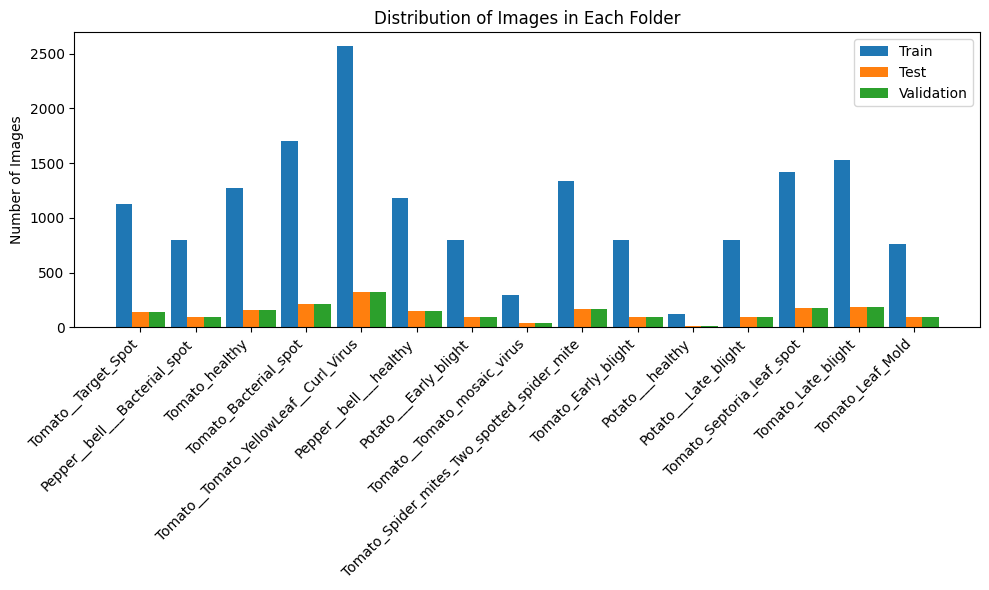

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

folders = ['train', 'test', 'validation']

subfolder_lengths = {folder: {} for folder in folders}

for folder in folders:
    subfolders = os.listdir(os.path.join(dataset_path, folder))
    for subfolder in subfolders:
        subfolder_length = len(os.listdir(os.path.join(dataset_path, folder, subfolder)))
        subfolder_lengths[folder][subfolder] = subfolder_length

subfolder_names = list(subfolder_lengths['train'].keys())
train_lengths = list(subfolder_lengths['train'].values())
test_lengths = list(subfolder_lengths['test'].values())
val_lengths = list(subfolder_lengths['validation'].values())

x = np.arange(len(subfolder_names))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, train_lengths, width, label='Train')
rects2 = ax.bar(x, test_lengths, width, label='Test')
rects3 = ax.bar(x + width, val_lengths, width, label='Validation')


ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Images in Each Folder')
ax.set_xticks(x)
ax.set_xticklabels(subfolder_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()


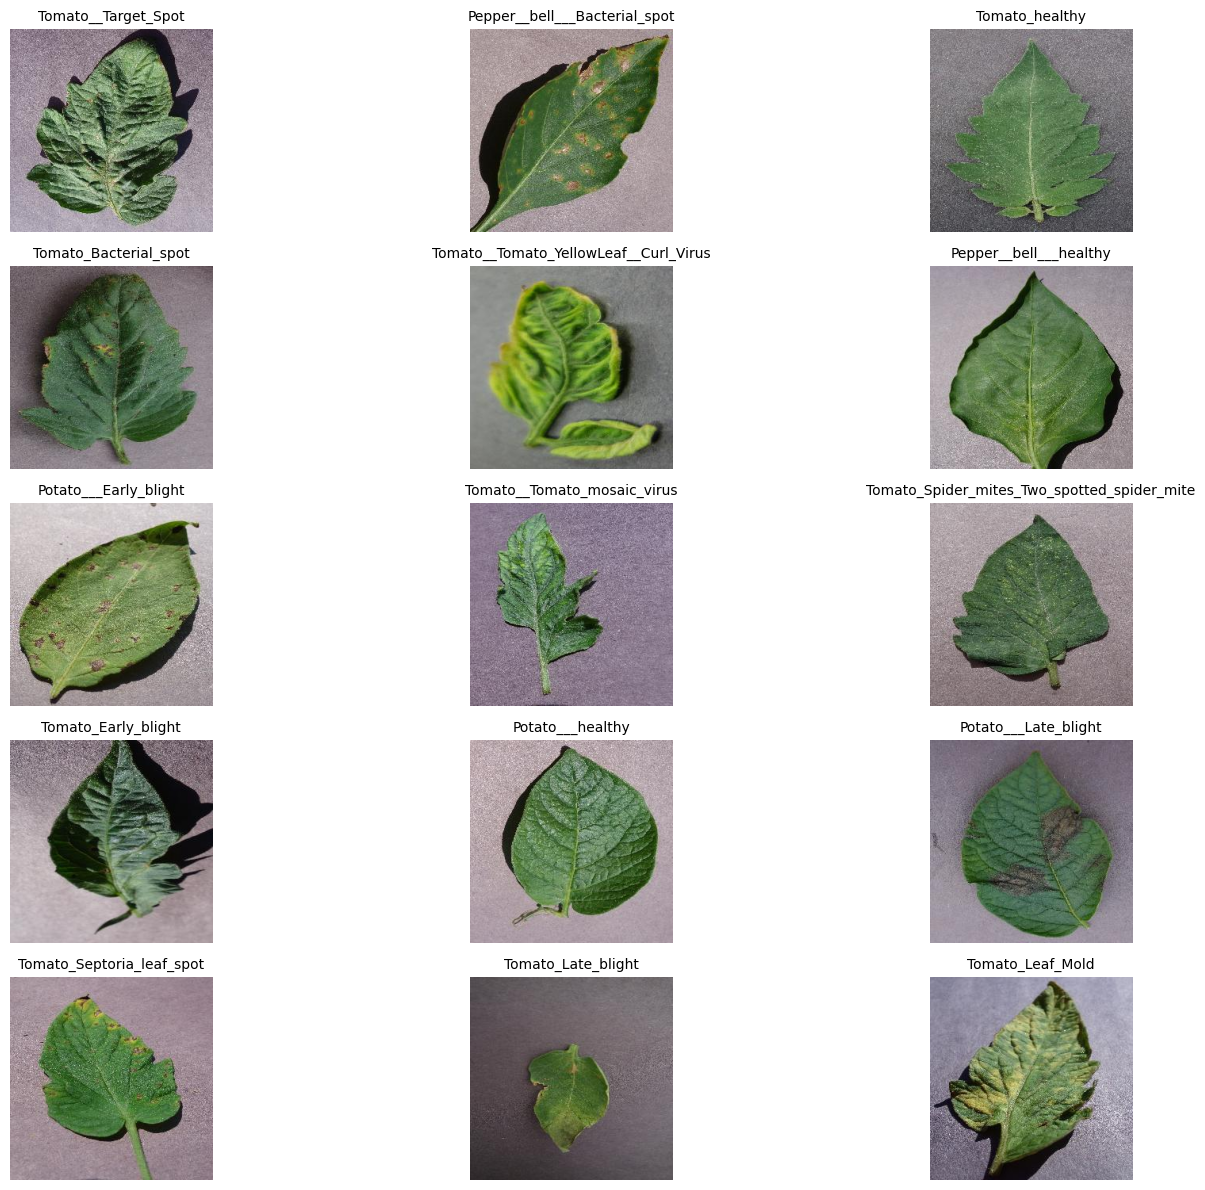

In [ ]:
import matplotlib.image as mpimg

# Create a grid to display the images
num_cols = 3  # Number of columns in the grid
num_rows = 5  # Calculate number of rows

# Create a matplotlib figure and axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Loop through subfolders and display an image from each
for i, subfolder in enumerate(subfolders):
    img = [image for image in os.listdir(os.path.join(train_path,subfolder))][0]

    img_path = os.path.join(train_path, subfolder, img)  # Get the first image in the subfolder
    img = mpimg.imread(img_path)  # Load the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(subfolder, color='black', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# Model Training

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
batch_size = 32
image_shape = (256,256)

train_datagen = ImageDataGenerator(

    rescale=1/255,
    shear_range=0.2,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range=[0.5, 1.5],  # Adjust brightness between 50% and 150%
    rotation_range=40,  # Rotate images by up to 40 degrees
    zoom_range = 0.2

)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical"

)

Found 16504 images belonging to 15 classes.


In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1/255,
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical"

)

Found 2070 images belonging to 15 classes.


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1/255,
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = False

)

Found 2064 images belonging to 15 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

tf.random.set_seed(42)

# Build your CNN model

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))

model.add(Dense(15, activation='softmax'))

# Compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])


# Define a ModelCheckpoint callback to save the best weights during training
checkpoint_callback = ModelCheckpoint("best_epoch_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [17]:
# Train the model
tf.random.set_seed(42)

steps_per_epoch = train_generator.n // batch_size     # 32
validation_steps = validation_generator.n // batch_size
epochs = 30

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]
)

# Find the epoch with the best accuracy on the validation (test) set
best_epoch = np.argmax(history.history['val_accuracy']) + 1

print(f"Best epoch {best_epoch}")

Epoch 1/30
515/515 [==============================] - ETA: 0s - loss: 1.7567 - accuracy: 0.4271
Epoch 1: val_accuracy improved from -inf to 0.67773, saving model to best_epoch_weights.h5
515/515 [==============================] - 1056s 2s/step - loss: 1.7567 - accuracy: 0.4271 - val_loss: 0.9506 - val_accuracy: 0.6777
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


515/515 [==============================] - ETA: 0s - loss: 0.8747 - accuracy: 0.7060
Epoch 2: val_accuracy improved from 0.67773 to 0.80957, saving model to best_epoch_weights.h5
515/515 [==============================] - 1045s 2s/step - loss: 0.8747 - accuracy: 0.7060 - val_loss: 0.6037 - val_accuracy: 0.8096
Epoch 3/30
515/515 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.7882
Epoch 3: val_accuracy improved from 0.80957 to 0.82178, saving model to best_epoch_weights.h5
515/515 [==============================] - 1049s 2s/step - loss: 0.6325 - accuracy: 0.7882 - val_loss: 0.5368 - val_accuracy: 0.8218
Epoch 4/30
515/515 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.8317
Epoch 4: val_accuracy improved from 0.82178 to 0.87207, saving model to best_epoch_weights.h5
515/515 [==============================] - 1040s 2s/step - loss: 0.4960 - accuracy: 0.8317 - val_loss: 0.4187 - val_accuracy: 0.8721
Epoch 5/30
515/515 [======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


515/515 [==============================] - ETA: 0s - loss: 0.8747 - accuracy: 0.7060
Epoch 2: val_accuracy improved from 0.67773 to 0.80957, saving model to best_epoch_weights.h5
515/515 [==============================] - 1045s 2s/step - loss: 0.8747 - accuracy: 0.7060 - val_loss: 0.6037 - val_accuracy: 0.8096
Epoch 3/30
515/515 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.7882
Epoch 3: val_accuracy improved from 0.80957 to 0.82178, saving model to best_epoch_weights.h5
515/515 [==============================] - 1049s 2s/step - loss: 0.6325 - accuracy: 0.7882 - val_loss: 0.5368 - val_accuracy: 0.8218
Epoch 4/30
515/515 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.8317
Epoch 4: val_accuracy improved from 0.82178 to 0.87207, saving model to best_epoch_weights.h5
515/515 [==============================] - 1040s 2s/step - loss: 0.4960 - accuracy: 0.8317 - val_loss: 0.4187 - val_accuracy: 0.8721
Epoch 5/30
515/515 [======================

In [19]:
# Save the entire model to a HDF5 file
model.save('disease_classification.h5')
